# MSA 2024 Phase 2 - Part 3

In [32]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical 

### 1. Load and split preprocessed data

In [2]:
# Prepare the training and testing image sets.
train_dir = '/kaggle/input/nzmsa-2024/cifar10_images/train'
test_dir = '/kaggle/input/nzmsa-2024/cifar10_images/test'



In [3]:
def loadTrain(root_dir, csv_file):
    ids = []
    images = []
    labels = []
    annotations = np.genfromtxt(csv_file, delimiter=',', names=True)
    for idx in range(len(annotations)):
        img_id = int(annotations['id'][idx])
        img_name = os.path.join(root_dir, f"image_{img_id}.png")
        image = np.array(Image.open(img_name).convert("RGB"))
        label = int(annotations['label'][idx])

        ids.append(img_id)
        images.append(image)
        labels.append(label)
    return np.array(ids), np.array(images), np.array(labels)

In [4]:
def loadTest(root_dir):
    ids = []
    images = []
    for idx in range(len(os.listdir(root_dir))):
        img_name = os.path.join(root_dir, f"image_{idx}.png")
        image = np.array(Image.open(img_name).convert("RGB"))

        ids.append(idx)
        images.append(image)
    return np.array(ids), np.array(images)

In [5]:
# Load training, testing data and the training label provided in train.csv.
train_csv = '/kaggle/input/nzmsa-2024/train.csv'
id_train, X_train, y_train = loadTrain(train_dir, train_csv)
id_test, X_test = loadTest(test_dir)

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')



x_train shape: (50000, 32, 32, 3)
y_train shape: (50000,)
50000 train samples
5000 test samples


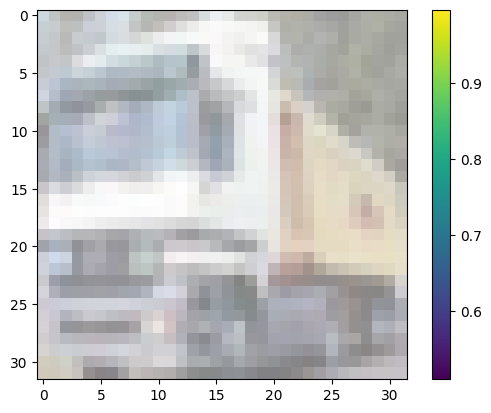

In [33]:
plt.figure()
plt.imshow(X_train[1])
plt.colorbar()

In [6]:
# Normalize the data to fit in to CNN model.
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert training labels to one-hot encoded vectors.
y_train = to_categorical(y_train, 10)

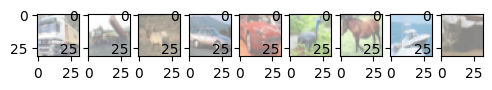

In [36]:
# Visualizing the first 10 images 
for i in range(1,10):
    plt.subplot(1, 10, i)
    plt.imshow(X_train[i])

### 2. Use CNN for train and test a model

In [26]:
# Model initialization.
model = tf.keras.Sequential()
 
# Define the CNN model.
model.add(Conv2D(64,(3,3),input_shape=(32,32,3),activation='relu',padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),input_shape=(32,32,3),activation='relu',padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),input_shape=(32,32,3),activation='relu',padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization()) # Normalizing the input layer by adjusting and scaling the activations
model.add(Conv2D(128,(3,3),input_shape=(32,32,3),activation='relu',padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3)) # Randomly dropping some neurons during the training process, to learn new features from the input data.

model.add(Conv2D(128,(3,3),input_shape=(32,32,3),activation='relu',padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),input_shape=(32,32,3),activation='relu',padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10,  activation="softmax"))

# Complile the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add data augmentation
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, rotation_range=10, validation_split=0.2)
train_generator = data_generator.flow(X_train, y_train, subset='training',shuffle=True,batch_size=32) 
validation_gen = data_generator.flow(X_train, y_train, subset='validation', shuffle=True,batch_size=32)

#Step_size_train=train_generator.n//32
#Step_size_valid=validation_gen.n//32
    
# Train the model.
History = model.fit(train_generator, epochs=20, batch_size=32, validation_data=validation_gen)

# Make predictions.
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Prepare your submission file.
submission = np.column_stack((id_test, predicted_labels))
np.savetxt('submission.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 385s 302ms/step - accuracy: 0.3123 - loss: 2.1525 - val_accuracy: 0.4329 - val_loss: 1.6443
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 387s 307ms/step - accuracy: 0.5262 - loss: 1.3273 - val_accuracy: 0.5452 - val_loss: 1.3376
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 387s 310ms/step - accuracy: 0.6237 - loss: 1.0678 - val_accuracy: 0.4440 - val_loss: 1.7557
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 433s 303ms/step - accuracy: 0.6633 - loss: 0.9563 - val_accuracy: 0.6806 - val_loss: 0.9187
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 385s 305ms/step - accuracy: 0.6950 - loss: 0.8712 - val_accuracy: 0.6259 - val_loss: 1.0659
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 400s 320ms/step - accuracy: 0.7293 - loss: 0.7922 - val_accuracy: 0.5847 - val_loss: 1.2778
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 375s 300ms/step - accuracy: 0.7473 - loss: 0.7374 - val_accuracy: 0.5344 - val_loss: 1.4885
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 376s 301ms/step - ac

In [30]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_114 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_133         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_134         │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_135         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_117 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_136         │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_138         │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_139         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,254,496 (12.41 MB)

 Trainable params: 1,084,234 (4.14 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 2,168,470 (8.27 MB)

### 3. Evaluate the model

In [41]:
evaluation = model.evaluate(X_train, y_train)
print('Test Accuracy: {}'.format(evaluation[1]))

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 112s 71ms/step - accuracy: 0.8553 - loss: 0.4241
Test Accuracy: 0.8626400232315063


Text(0, 0.5, 'Loss')

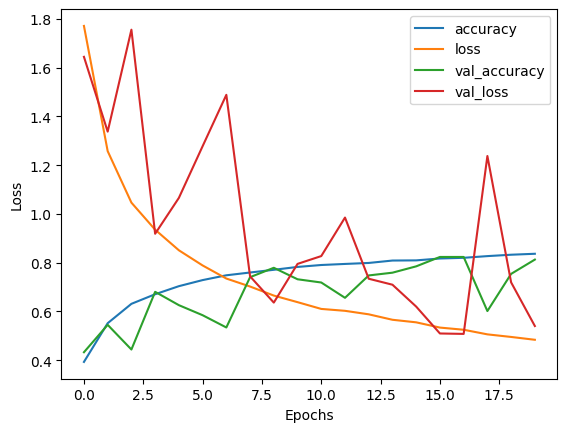

In [40]:
pd.DataFrame(History.history).plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### 4. Summary